In [17]:
!pip install transformers
import collections
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
puncs = string.punctuation.replace('*', '').replace('#', '')
table = str.maketrans('', '', puncs)
import re
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, BertModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [19]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token)
print(roberta_model.config.vocab_size)

50265
<pad>
50265


In [20]:
roberta_model.embeddings

RobertaEmbeddings(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [21]:
roberta_model.encoder.layer[0]

RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): RobertaOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [22]:
def checks(w):
    if w in stop_words: return False
    if re.search('[a-zA-Z]', w) and '*' in w: return True
    if not w.isalpha(): return False
    if len(w) == 1 and w not in ['a', 'i', 'o', 'u']: return False
    return True

In [23]:
def getWordCounts(texts, scores, word_tokens):
  l = len(texts)
  wordCounts = {}
  for i in range(l):
    if i % 10000 == 0: print(i)
    text, score = texts[i], scores[i]
    wtoks = word_tokens[i]
    for w in wtoks:
      w = w.strip()
      if w[0] == 'Ġ': w = w[1:]
      w = w.lower()
      w = w.translate(table)
      if not checks(w): continue
      wordCounts[w] = wordCounts.get(w, 0) + 1
  return wordCounts

In [24]:
def getWordSentences(texts, word_tokens):
    l = len(texts)
    wordSentences = collections.defaultdict(list)
    for i in range(l):
        if i % 10000 == 0: print(i)
        text = texts[i]
        text = text.lower()
        wtoks = word_tokens[i]
        for w in wtoks:
            w = w.strip()
            if w[0] == 'Ġ': w = w[1:]
            w = w.lower()
            w = w.translate(table)
            # w = porter.stem(w)
            if not checks(w): continue
            wordSentences[w].append(text)
    return wordSentences

In [25]:
def getSortedWordScores(wordCounts, asc=False):
    rows_list = []
    for i,w in enumerate(wordCounts):
        dic = {'Word': w, 'Count': wordCounts[w]}
        rows_list.append(dic)
        
    wordScores = pd.DataFrame(rows_list, columns=['Word', 'Count'])
    
    return wordScores

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DetoxBert/'

Mounted at /content/drive


In [27]:
rows = []
with open(path+'toxic.tsv', 'r') as f:
  lines = f.readlines()
  columns = lines[0].split('\t')
  num_cols = len(columns)
  lines = lines[1:]
  for line in lines:
    fields = line.split('\t')
    if len(fields) > num_cols:
      fields = [' '.join(fields[:-num_cols])] + fields[-num_cols:]
    elif len(fields) < num_cols:      
      for i in range(num_cols - len(fields)):
        fields.append('0')
    rows.append(fields)

df = pd.DataFrame(np.array(rows), columns=columns)


In [28]:

# df = pd.read_csv(path+'toxic_fixed.tsv', sep='\t', encoding='utf-8')
print('done: read file')
# only check toxicity values, todo: check others as well

# df = df[['Text', 'Tox']]
df = df[['Text', 'Sev_Tox']]

df.columns = ['Text', 'Score']
df.Score = df.Score.astype(float)
df = df.fillna(0)
toxic_df = df[df['Score'] >= 0.5]
nontox_df = df[df['Score'] < 0.5]
print('done: got toxic data >=0.5')

done: read file
done: got toxic data >=0.5


In [29]:
toxic_df[:3]['Text'].to_numpy()

array(['That violence is both promoted by the government—one parliamentarian has said if he had a lesbian daughter, he would hang her—and carried out by private citizens with government complicity.',
       'In the latest incident, a car bomb exploded at a petrol station in the government-held Damascus suburb of Barzeh, killing 11 people, including civilians, and injuring 40 more, according to both government and opposition reports.',
       'Sebastopol’s local newspaper reports that seven of the 26 people murdered in Sonoma County since 2013 died during marijuana deals.'],
      dtype=object)

In [30]:
# df = pd.read_csv(path+'toxic.tsv', sep='\t+', encoding='utf-8')

pd.set_option('display.max_colwidth', None)
te = toxic_df[toxic_df['Text'].str.contains('If I fought Rafael dos Anjos')]['Text']
te

56112    "If I fought Rafael dos Anjos, if he didn't pussy out of that last one and showed up, the shots I cracked Nate with in the first eight minutes of that [fight] would've KO'd Rafael dos Anjos stiff.
Name: Text, dtype: object

In [31]:
texts = df['Text'].to_numpy()
scores = df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcAll = getWordCounts(texts, scores, word_tokens)
wsentAll = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [32]:
# t = "An impatient commuter probably regretted telling a man to 'f**k himself' on a busy train."
# print(t)
# print(encoded_texts[0])
print(tokenizer.encode(word_tokens[0]))
print(len(wsentAll['pussy']))

[0, 15228, 26858, 3329, 5, 9617, 16, 5, 834, 17685, 13, 5, 1789, 17, 27, 29, 1272, 6, 309, 7, 10, 485, 266, 31, 5, 3672, 12412, 1292, 13, 4035, 35411, 578, 102, 2764, 42223, 2368, 12, 14785, 1070, 10707, 1218, 4, 2]
178


In [33]:
texts = toxic_df['Text'].to_numpy()
scores = toxic_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcTox = getWordCounts(texts, scores, word_tokens)
wsentTox = getWordSentences(texts, word_tokens)

0
10000
20000
30000
0
10000
20000
30000


In [34]:
texts = nontox_df['Text'].to_numpy()
scores = nontox_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcNT = getWordCounts(texts, scores, word_tokens)
wsentNT = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000


In [35]:
print(len(wcAll))
print(len(wcTox))
print(len(wcNT))

28689
24253
27905


In [36]:
wordScoresAll = getSortedWordScores(wcAll)

In [37]:
wordScoresTox = getSortedWordScores(wcTox)

In [38]:
wordScoresNT = getSortedWordScores(wcNT, asc=True)

In [39]:
print('All\n', wordScoresAll.head())
print('Toxic\n', wordScoresTox.head())
print('NonToxic\n', wordScoresNT.head())

All
           Word  Count
0          cor    179
1      ruption     12
2    involving     83
3  contractors     13
4        chief    342
Toxic
          Word  Count
0    violence    122
1    promoted     13
2  government    234
3         âģķ   1473
4         one   2547
NonToxic
           Word  Count
0          cor    112
1      ruption     12
2    involving     67
3  contractors     11
4        chief    275


In [40]:
sAll, sTox, sNT = wordScoresAll, wordScoresTox, wordScoresNT

In [41]:
sAll[sAll['Word'] == 'like'], sTox[sTox['Word'] == 'like'], sNT[sNT['Word'] == 'like']

(     Word  Count
 114  like   5748,      Word  Count
 576  like   2714,      Word  Count
 114  like   3034)

In [42]:
from functools import reduce

dfs = [sAll, sTox, sNT]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='Word'), dfs)

In [43]:
df_merged.columns = ['Word', 'Count_All', 'Count_Tox', 'Count_NT']
df_merged.head()

,Word,Count_All,Count_Tox,Count_NT
0,cor,179,67,112
1,involving,83,16,67
2,contractors,13,2,11
3,chief,342,67,275
4,culprit,25,3,22


In [44]:
df_merged['Tox_percent'] = df_merged.apply (lambda row: row['Count_Tox']/(row['Count_All']), axis=1)

In [45]:
df_merged[df_merged['Word'] == 'fuck']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
22011,fuck,1705,1664,41,0.975953


In [46]:
MINFREQ = 3
df_merged_minfreq = df_merged[(df_merged['Count_All'] > MINFREQ)]

In [47]:
# highTox = df_merged_minfreq.sort_values(["Count_All", "Tox_percent"], ascending = [False, False])

In [48]:
# highTox = df_merged_minfreq.sort_values(["Count_NT", "Count_Tox"], ascending = [True, False])
highTox = df_merged_minfreq.sort_values("Tox_percent", ascending = False)
len(highTox)

21780

In [49]:
highTox[:20]

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
23170,pussy,178,177,1,0.994382
23216,whore,149,148,1,0.993289
23105,bitch,562,551,11,0.980427
22011,fuck,1705,1664,41,0.975953
23235,asshole,296,288,8,0.972973
23171,slut,135,131,4,0.970370
22682,fucking,1291,1243,48,0.962820
14839,cking,99,95,4,0.959596
23128,fucked,267,256,11,0.958801
21394,igger,69,66,3,0.956522


In [50]:
# highTox[:20]

In [51]:
ht = highTox[:]

In [52]:
ht[ht['Word'] == 'damn']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
17788,damn,648,406,242,0.626543


In [53]:
toxword = ht['Word'][:1]
toxsents = wsentTox['pussy'][:20]
for i, s in enumerate(toxsents):
  if '\t' in s:
    print(i)
    print(s)
    print()

In [54]:
# todo: Compute PMI

In [56]:
import sklearn as sl
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plotVariance(y, title=""):
  x = range(len(y))
  plt.plot(x, y)
  plt.title(title)
  plt.show()
  plt.savefig(title)


# Computes PCs of difference vector
def getPrincipalComponents(D, num_comp=None):
  pca = PCA(n_components=num_comp, svd_solver="auto")
  X = D[0].cpu().detach().numpy()
  pca.fit(X)
  exp_var = pca.explained_variance_ratio_
  return torch.Tensor(np.array(pca.components_)), exp_var

In [57]:
def projection(a, b):
  inner = torch.mm(a, b.T)
  res = a - torch.mm(inner, b)
  return res

**Debiasing Roberta**

In [58]:
num_words = 10
num_sents = 10
print(tokenizer.pad_token)
print(roberta_model.config.vocab_size)
print(roberta_model.embeddings)
print(roberta_model.encoder.layer[0])

<pad>
50265
RobertaEmbeddings(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): Rob

In [67]:
class LayerRoberta(nn.Module):

  def __init__(self):
    super(LayerRoberta, self).__init__()
    self.emb = roberta_model.embeddings
    self.blocks = roberta_model.encoder.layer
    self.bert = bert_model


  def forward(self, layer_num, inp, attn_masks):
    
    if layer_num == 0:
      input_shape = inp.size()
      inp = inp.view(-1, input_shape[-1])
      batch_size = inp.shape[0]

      device = inp.device
      
      return self.emb(inp)

    else:
      block = self.blocks[layer_num-1]
      device = inp.device
      input_shape = inp.size()
      ext_attn_mask: torch.Tensor = self.bert.get_extended_attention_mask(attn_masks, input_shape, device)
      return block(inp, ext_attn_mask)[0]
      
    # hidden_states = self.ln_f(hidden_states)
    # output_shape = input_shape + (hidden_states.size(-1),)
    # hidden_states = hidden_states.view(*output_shape)



layerRoberta = LayerRoberta()
layerRoberta = layerRoberta.cuda()
# device = torch.device('cpu')
# layerGpt2 = layerGpt2.to(device)


In [68]:
# this algorithm takes in toxic sentence and corresponsing nontoxic sentence
# and returns layer wise PC set {P_0, ..., P_12}
def run_roberta_algorithm(S_t, S_nt, model, debias=True):
    # inputs are encoded sentences
    W_t, W_nt = S_t, S_nt

    inp_ids_t, attn_masks_t = W_t['input_ids'], W_t['attention_mask']
    inp_ids_nt, attn_masks_nt = W_nt['input_ids'], W_nt['attention_mask']

    u, v, D, PCs, ev = [None] * 13, [None] * 13, [None] * 13, [None] * 13, [None] * 13
    
    inp_t = inp_ids_t.cuda()
    atn_t = attn_masks_t.cuda()
    # inp_t = inp_ids_t
    # atn_t = attn_masks_t
    
    # print('inp_t', inp_t.shape, 'atn_t', atn_t.shape)
    u[0] = model(0, inp_t, atn_t)
    # print('u[0]', u[0].shape)

    inp_nt = inp_ids_nt.cuda()
    atn_nt = attn_masks_nt.cuda()
    # inp_nt = inp_ids_nt
    # atn_nt = attn_masks_nt
    
    v[0] = model(0, inp_nt, atn_nt)
    
    D[0] = u[0] - v[0]  # todo: check dim, torch. ?
    # print('D[0]', D[0].shape)
    PCs[0], ev[0] = getPrincipalComponents(D[0])
    
    PCs[0] = PCs[0].cuda()
    # print('PC[0]', PCs[0].shape, 'ev[0]', ev[0].shape)

    for j in range(1, 13):
        # print("BERT Layer j =", j)
        if debias:
          uproj = projection(u[j - 1][0], PCs[j - 1])
          vproj = projection(v[j - 1][0], PCs[j - 1])
        else:
          uproj = u[j-1][0]
          vproj = v[j-1][0]

        uproj = uproj.unsqueeze(dim=0).cuda()
        vproj = vproj.unsqueeze(dim=0).cuda()
        u[j] = model(j, uproj, atn_t)
        v[j] = model(j, vproj, atn_nt)
        
        D[j] = u[j] - v[j]  # todo: check dim, torch. ?
        PCs[j], ev[j] = getPrincipalComponents(D[j])
        PCs[j] = PCs[j].cuda()

        # print('PCs[j]', PCs[j].shape)

    return PCs, ev


In [71]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    # print(tox)
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == 'Ġ' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_roberta_algorithm(encoded_T, encoded_NT, layerRoberta, debias=True)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word pussy num_sent 10
0
tensor([[    0,   627,   299,   158, 14016,   607,  7758,  4060, 20616,    32,
         17072, 34781,     6, 17072,  1898,     6, 14844,     6,  6814,     6,
         17072,  1898,  4111,  5046,     6,  2231, 14682,  2553,     6, 17072,
          1898, 37628,     6,  4091,   438, 19644,     6, 42167,     6,     8,
         17072,  1898,  4111,     4,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     

First PCs [100.0, 28.981518, 48.27066, 47.82793, 47.344997, 46.571667, 46.32476, 46.679157, 46.33167, 46.465862, 47.43251, 46.4929, 46.029984]


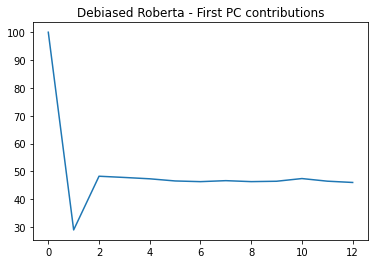

Second PCs [7.08202e-13, 14.723998, 4.4016786, 3.9982092, 4.285382, 5.0628886, 4.3898115, 5.1879964, 5.7801924, 5.4304886, 5.197697, 5.760583, 5.7847967]


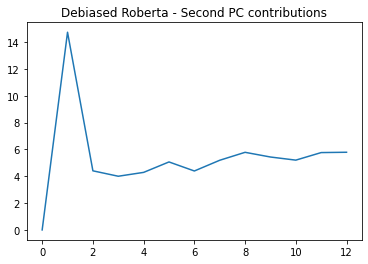

Third PCs [3.5527137e-13, 5.3286114, 2.8925402, 2.838135, 2.9933295, 2.9538424, 3.0003874, 3.191889, 2.934276, 3.2050614, 2.8345983, 2.9785028, 3.4307387]


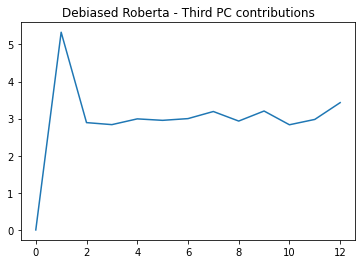

<Figure size 432x288 with 0 Axes>

In [72]:
ev = [e/count*100 for e in ev]
ev1 = ev

first_pcs = [f[0] for f in ev1]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Debiased Roberta - First PC contributions')

second_pcs = [f[1] for f in ev1]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Debiased Roberta - Second PC contributions')

third_pcs = [f[2] for f in ev1]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Debiased Roberta - Third PC contributions')

**Normal GPT2**

In [74]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == 'Ġ' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      # print(tokens)
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_roberta_algorithm(encoded_T, encoded_NT, layerRoberta, debias=False)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word pussy num_sent 10
0
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) atn_t torch.Size([1, 256])
u[0] torch.Size([1, 256, 768])
D[0] torch.Size([1, 256, 768])
PC[0] torch.Size([256, 768]) ev[0] (256,)
inp_t torch.Size([1, 256]) 

First PCs [100.0, 83.37503, 71.67365, 59.544228, 55.308254, 54.80538, 54.887547, 53.373356, 52.425564, 52.03517, 52.891262, 55.0673, 52.09275]


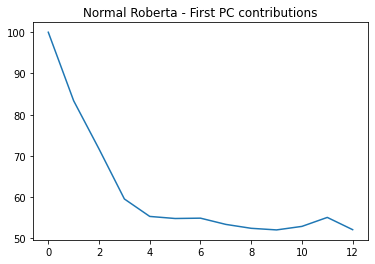

Second PCs [7.08202e-13, 6.469295, 11.857852, 16.82483, 19.168299, 18.877048, 19.284304, 19.960276, 20.263216, 19.86512, 18.9958, 17.295881, 16.06329]


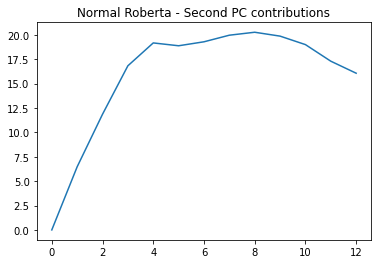

Third PCs [3.5527137e-13, 2.9136376, 5.1076584, 6.7143126, 7.213304, 7.2978625, 7.0799136, 7.3865833, 7.359327, 7.474658, 7.4385514, 6.942851, 6.8356447]


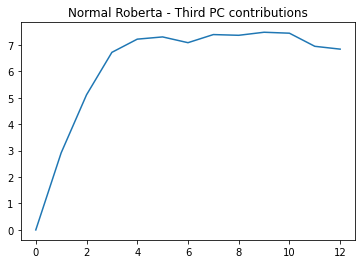

<Figure size 432x288 with 0 Axes>

In [75]:
ev = [e/count*100 for e in ev]
ev2 = ev

first_pcs = [f[0] for f in ev2]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Normal Roberta - First PC contributions')

second_pcs = [f[1] for f in ev2]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Normal Roberta - Second PC contributions')

third_pcs = [f[2] for f in ev2]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Normal Roberta - Third PC contributions')

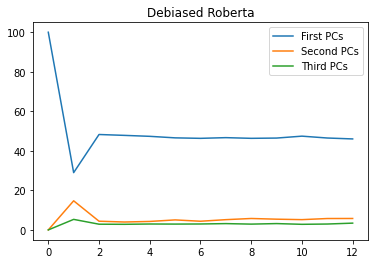

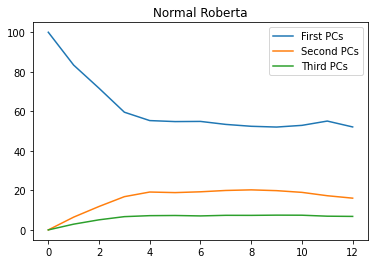

In [76]:
first_pcs = [f[0] for f in ev1]
second_pcs = [f[1] for f in ev1]
third_pcs = [f[2] for f in ev1]

x = range(len(first_pcs))
plt.plot(x, first_pcs)
plt.plot(x, second_pcs)
plt.plot(x, third_pcs)
plt.title("Debiased Roberta")
plt.legend(['First PCs', 'Second PCs', 'Third PCs'])
plt.show()

first_pcs = [f[0] for f in ev2]
second_pcs = [f[1] for f in ev2]
third_pcs = [f[2] for f in ev2]

x = range(len(first_pcs))
plt.plot(x, first_pcs)
plt.plot(x, second_pcs)
plt.plot(x, third_pcs)
plt.title("Normal Roberta")
plt.legend(['First PCs', 'Second PCs', 'Third PCs'])
plt.show()